In [91]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tqdm as tqdm

# Function to determine probability of switching

In [ ]:
# def probability_at_time(pc, n_coop_cur, n_coop_pop, n_trials_cur, n_trials_pop, pop_info): # p is probability of current partner coop; n_total is the number of trials
#     a = 1 # flat priors
#     b = 1

#     pc = pc
#     switch_fit_multiplier = 1 # can add explicit cost of switching (1 = no cost)

#     T = 0.8 # D / C
#     R = 0.6 # C / C
#     P = 0.2 # D / D
#     S = 0.4 # C / D
    
#     population_a = a + pop_info * n_coop_pop
#     population_b = b + pop_info * (n_trials_pop - n_coop_pop)
        
#     current_a = population_a + n_coop_cur
#     current_b = population_b + (n_trials_cur - n_coop_cur)

#     samples_current = stats.beta.rvs(current_a, current_b, size=10000)
#     samples_population = stats.beta.rvs(population_a, population_b, size=10000)

#     staying_fitness =  (
#             samples_current * (pc * R + (1 - pc) * T) +
#             (1 - samples_current) * (pc * S + (1 - pc) * P)
#         )

#     switching_fitness =  (
#             samples_population * (pc * R + (1 - pc) * T) +
#             (1 - samples_population) * (pc * S + (1 - pc) * P)
#         )

#     payoff_difference = (switching_fitness * switch_fit_multiplier) - staying_fitness
#     ps = np.mean(payoff_difference > 0) # expectation that switching is better than staying
    
#     payoff = ps * (switching_fitness * switch_fit_multiplier) + (1 - ps) * staying_fitness # expected payoff
    
#     return list([ps, np.mean(payoff), samples_current, samples_population])

In [257]:
def estimate_beta_moments(samples):
    """
    Estimate alpha and beta using the method of moments.
    
    Parameters:
    - samples (array-like): Observed data from a Beta distribution (values in (0,1))
    
    Returns:
    - dict: Estimated alpha and beta
    """
    alpha_prior = 1
    beta_prior = 1
    prior_weight = 0.1
    
    prior_mean = alpha_prior/(alpha_prior + beta_prior)
    prior_var = (alpha_prior * beta_prior) / ((alpha_prior + beta_prior)**2 * (alpha_prior + beta_prior + 1))

    samples = np.asarray(samples)
    sample_mean = np.mean(samples)
    sample_var = np.var(samples, ddof=1)

    mean = (1 - prior_weight) * sample_mean + prior_weight * prior_mean
    var = (1 - prior_weight) * sample_var + prior_weight * prior_var

    # Moment estimates
    common = mean * (1 - mean) / var - 1
    alpha = mean * common
    beta = (1 - mean) * common
    
    if np.isinf(alpha) or np.isinf(beta):
        print(samples)
        
    return alpha, beta

In [258]:
np.var([0.5, 0.5, 0.5])

0.0

In [ ]:
def probability_at_time(pc, n_coop_cur, n_coop_pop, n_trials_cur, n_trials_pop, pop_info, population_probs): # p is probability of current partner coop; n_total is the number of trials

    pc = pc
    switch_fit_multiplier = 1 # can add explicit cost of switching (1 = no cost)

    T = 0.8 # D / C
    R = 0.6 # C / C
    P = 0.2 # D / D
    S = 0.4 # C / D
    
    
    # population_a = a + pop_info * n_coop_pop
    # population_b = b + pop_info * (n_trials_pop - n_coop_pop)
    if len(population_probs) > 2:
        # a_estimate, b_estimate, c, y = stats.beta.fit(population_probs)
        a_estimate, b_estimate = estimate_beta_moments(population_probs)
        population_a = a_estimate * pop_info # based on the probabilities of cooperating oberved, work out a and b
        population_b = b_estimate * pop_info # population probs is probabilities observed of each individual in the population cooperating
    else: # on first iteration, use flat priors
        population_a = 1
        population_b = 1

    current_a = population_a + n_coop_cur
    current_b = population_b + (n_trials_cur - n_coop_cur)

    # print(current_a, current_b, population_a, population_b)
    # print(population_probs)

    samples_current = stats.beta.rvs(current_a, current_b, size=10000)
    samples_population = stats.beta.rvs(population_a, population_b, size=10000)

    staying_fitness =  (
            samples_current * (pc * R + (1 - pc) * T) +
            (1 - samples_current) * (pc * S + (1 - pc) * P)
        )

    switching_fitness =  (
            samples_population * (pc * R + (1 - pc) * T) +
            (1 - samples_population) * (pc * S + (1 - pc) * P)
        )

    payoff_difference = (switching_fitness * switch_fit_multiplier) - staying_fitness
    ps = np.mean(payoff_difference > 0) # expectation that switching is better than staying
    
    payoff = ps * (switching_fitness * switch_fit_multiplier) + (1 - ps) * staying_fitness # expected payoff
        
    return list([ps, np.mean(payoff), samples_current, samples_population])

# Model components

In [265]:
class Population:
    def __init__(self):
        self.animals = []

    def attach_animal(self, animal):
        self.animals.append(animal)
        animal.population = self

    def summary(self):
        return [animal.summary() for animal in self.animals]

class Animal:
    def __init__(self, id, pc, pop_info):
        self.id = id
        self.pc = pc
        self.pop_info = pop_info
        self.ps = 0

        self.partner = None
        self.payoff = 0
        self.n_partners = 0
        self.n_partners_switched_from = 0
        self.n_coop_cur = 0
        self.n_coop_pop = 0
        self.n_trials_cur = 0
        self.n_trials_pop = 0
        self.population = None
        self.population_probs = []

    def step(self, i):
        self._reckoning() # calculate payoff
        
        if self.partner is None:
            self._find_new_partner() # the animal now has a partner for this round
            
        self.ps, self.payoff, self.samples_current, self.samples_population = probability_at_time(self.pc, self.n_coop_cur, self.n_coop_pop, self.n_trials_cur, self.n_trials_pop, x, self.population_probs) # probability of switching and payoff

        self.n_coop_cur += round(self.partner.pc, 0) # update number of cooperative events and total events with current partner and population (binary cooperate or not)
        self.n_trials_cur += 1

        if self.ps > np.random.uniform(0, 1): # find new partner with probability ps
            # self.n_coop_pop += round(self.n_coop_cur/self.n_trials_cur, 0) # update -- was current partner cooperative?
            # self.n_trials_pop += 1                                         # update partners sampled
            # estimated_partner_pc = self.n_coop_cur/self.n_trials_cur
            estimated_partner_pc = np.mean(self.samples_current) # estimate of the probability of cooperating with the current partner
            if estimated_partner_pc <= 0:
                estimated_partner_pc += 0.000001
            if estimated_partner_pc >= 1:
                estimated_partner_pc -= 0.000001
            self.population_probs.append(estimated_partner_pc) # add to the list of probabilities observed
            self._find_new_partner()

    def _reckoning(self):
        payoff = 0
        if self.partner is None:
            payoff = 0.4
        elif self.partner is not None:
            if round(self.partner.pc, 0) == 1:  # if my partner cooperates
                if round(self.pc, 0) == 1:      # if I cooperate
                    payoff = 0.6
                else:                           # if I defect
                    payoff = 0.8
            else:                               # if my partner defects
                if round(self.pc, 0) == 1:      # if I cooperate
                    payoff = 0.4
                else:                           # if I defect
                    payoff = 0.2
        self.payoff = payoff

    def _find_new_partner(self):
        candidate_partners = self.population.animals.copy()
        candidate_partners.remove(self)
        if self.partner is not None:
            self.partner.n_partners_switched_from += 1
            candidate_partners.remove(self.partner)
            self.partner.partner = None
            self.partner = None
        for animal in candidate_partners:
                if animal.partner is not None:
                    candidate_partners.remove(animal)
        if len(candidate_partners) > 0:
            self.partner = np.random.choice(candidate_partners)
            self.partner.partner = self
            self.n_partners += 1
            self.n_coop_cur = 0
            self.n_trials_cur = 0
        else:
            self.partner = None
    
 

# Model run

In [303]:
all_mean_n_partners = []
all_uncertainty = []
all_mean_pc = []
all_mean_ps = []
all_iterations = []
all_mean_payoff = []
all_mean_partner_pc = []
all_mean_switched_from = []

combined_individual_data = []
combined_group_data = []

pop_info = np.arange(0.1, 1, 0.1)

num_iterations = 10
num_timesteps = 10000
for x in tqdm.tqdm(pop_info):
    for j in np.arange(0, num_iterations):
        population_size = 10
        population = Population()

        for id in range(population_size):
            population.attach_animal(Animal(id, stats.beta.rvs(3, 3, size=1)[0], x)) 

        for i in range(num_timesteps): 
            animal = np.random.choice(population.animals) # one animal per timestep
            animal.step(i)
        
        # Store individual values AT THE END
        for animal in population.animals:
                animal_data = {
                    'iteration': j,
                    'id': animal.id,
                    'pop_info': x,
                    'ps': animal.ps,
                    'pc': animal.pc,
                    'pc_estimate': animal.population_probs[-1],
                    'payoff': animal.payoff,
                    'partner_pc': animal.partner.pc if animal.partner is not None else None,
                    'switched_from': animal.n_partners_switched_from,
                    'n_partners': animal.n_partners
                }
                combined_individual_data.append(animal_data)

        # Store group means AT THE END
        group_data = {
            'iteration': j,
            'pop_info': x,
            'mean_ps': np.mean([animal.ps for animal in population.animals]),
            'mean_pc': np.mean([animal.pc for animal in population.animals]),
            'mean_payoff': np.mean([animal.payoff for animal in population.animals]),
            'mean_partner_pc': np.mean([animal.partner.pc for animal in population.animals if animal.partner is not None]),
            'mean_switched_from': np.mean([animal.n_partners_switched_from for animal in population.animals]),
            'mean_n_partners': np.mean([animal.n_partners for animal in population.animals])
        }
        combined_group_data.append(group_data)

individual_df = pd.DataFrame(combined_individual_data)
group_df = pd.DataFrame(combined_group_data)

100%|██████████| 9/9 [14:06<00:00, 94.09s/it]


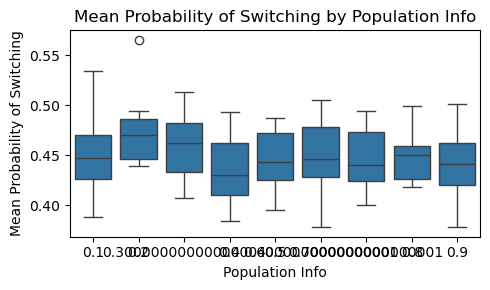

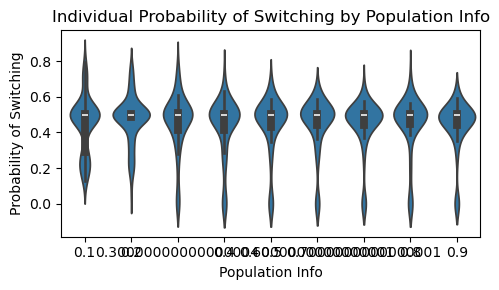

In [304]:
# Boxplot of group means ps for each population info
plt.figure(figsize=(5, 3))
sns.boxplot(x='pop_info', y='mean_ps', data=group_df)
plt.title('Mean Probability of Switching by Population Info')
plt.xlabel('Population Info')
plt.ylabel('Mean Probability of Switching')
plt.tight_layout()
plt.show()

# Violin plot of individual ps for each population info
plt.figure(figsize=(5, 3))
sns.violinplot(x='pop_info', y='ps', data=individual_df)
plt.title('Individual Probability of Switching by Population Info')
plt.xlabel('Population Info')
plt.ylabel('Probability of Switching')
plt.tight_layout()
plt.show()

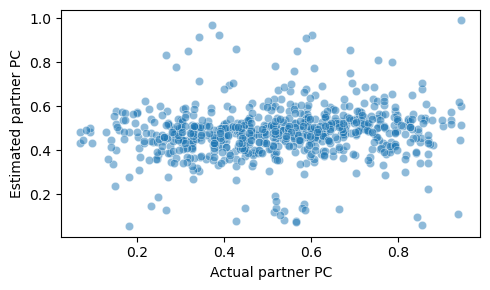

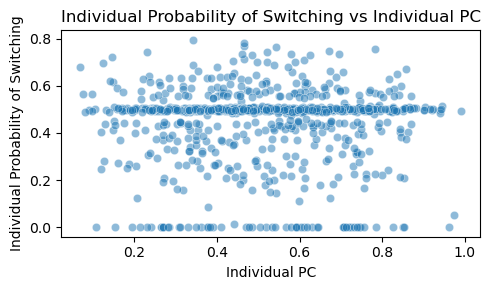

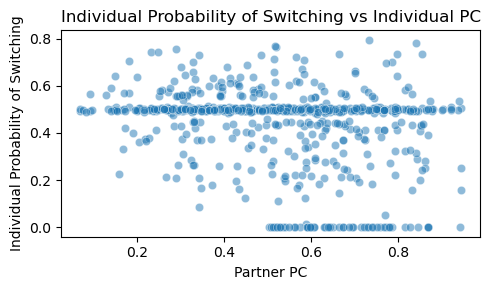

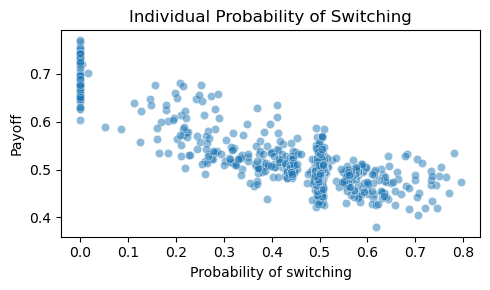

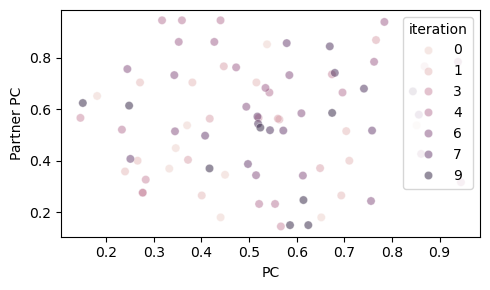

In [306]:
plt.figure(figsize=(5, 3))
sns.scatterplot(x='partner_pc', y='pc_estimate', data=individual_df, alpha=0.5)
plt.xlabel('Actual partner PC')
plt.ylabel('Estimated partner PC')
# plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# plot individual probability of switching against individual pc
plt.figure(figsize=(5, 3))
sns.scatterplot(x='pc', y='ps', data=individual_df, alpha=0.5)
plt.title('Individual Probability of Switching vs Individual PC')
plt.xlabel('Individual PC')
plt.ylabel('Individual Probability of Switching')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
sns.scatterplot(x='partner_pc', y='ps', data=individual_df, alpha=0.5)
plt.title('Individual Probability of Switching vs Individual PC')
plt.xlabel('Partner PC')
plt.ylabel('Individual Probability of Switching')
plt.tight_layout()
plt.show()

# individual_df['pc_diff'] = individual_df['pc'] - individual_df['partner_pc']
# plt.figure(figsize=(5, 3))
# sns.scatterplot(x='pc_diff', y='ps', data=individual_df, alpha=0.5)
# plt.title('Difference in cooperativeness')
# plt.xlabel('Individual PC Difference')
# plt.ylabel('Individual Probability of Switching')
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(5, 3))
sns.scatterplot(x='ps', y='payoff', data=individual_df, alpha=0.5)
plt.title('Individual Probability of Switching')
plt.xlabel('Probability of switching')
plt.ylabel('Payoff')
# plt.xlim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
sns.scatterplot(x='pc', y='partner_pc', data=individual_df[individual_df['pop_info']==0.1], hue= 'iteration', alpha=0.5)
plt.xlabel('PC')
plt.ylabel('Partner PC')
# plt.xlim(0, 1)
plt.tight_layout()
plt.show()



In [290]:
individual_df.describe()

,iteration,id,pop_info,ps,pc,payoff,partner_pc,switched_from,n_partners
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,363.000000,450.000000,450.000000
mean,2.000000,4.500000,0.500000,0.466284,0.505771,0.511765,0.519476,46.537778,66.255556
std,1.415788,2.875478,0.258486,0.127718,0.195045,0.046663,0.190378,15.567073,13.085602
min,0.000000,0.000000,0.100000,0.000000,0.061245,0.406866,0.083856,1.000000,5.000000
25%,1.000000,2.000000,0.300000,0.484775,0.355488,0.484262,0.366883,40.000000,59.000000
50%,2.000000,4.500000,0.500000,0.499300,0.516784,0.502657,0.530631,48.000000,67.000000
75%,3.000000,7.000000,0.700000,0.505550,0.652521,0.524988,0.659802,56.000000,74.750000
max,4.000000,9.000000,0.900000,0.749800,0.912747,0.712834,0.912747,94.000000,100.000000


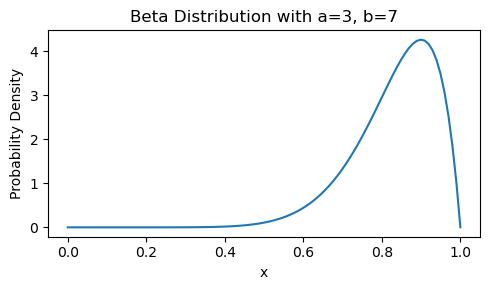

In [295]:
# plot beta distribution with a and b parameters
a = 10
b = 2
x = np.linspace(0, 1, 100)
y = stats.beta.pdf(x, a, b)
plt.figure(figsize=(5, 3))
plt.plot(x, y)
plt.title('Beta Distribution with a=3, b=7')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()